<h1 align="center"> Image Captioning </h1>

In this notebook you will teach a network to do image captioning
![img](https://cdn-images-1.medium.com/max/716/1*vzFwXFJOrg6WRGNsYYT6qg.png)
_image [source](https://towardsdatascience.com/image-captioning-in-deep-learning-9cd23fb4d8d2)_



#### Alright, here's our plan:
1. Take a pre-trained inception v3 to vectorize images
2. Stack an LSTM on top of it
3. Train the thing on [MSCOCO](http://cocodataset.org/#download)

In [1]:
# Please eithrer download data from https://yadi.sk/d/b4nAwIE73TVcp5 or generate it manually with preprocess_data.

### Data preprocessing

In [2]:
%%time
# Read Dataset
import numpy as np
import json

img_codes = np.load("data/image_codes.npy")
captions = json.load(open('data/captions_tokenized.json'))

CPU times: user 146 ms, sys: 328 ms, total: 474 ms
Wall time: 474 ms


### Data structure

To save your time, we've already vectorized all MSCOCO17 images with a pre-trained inception_v3 network from [torchvision](https://github.com/pytorch/vision/blob/master/torchvision/models/inception.py).

The whole process takes anywhere between a day on CPU and 10min on 3x tesla m40. If you want to play with that yourself, [you're welcome](https://gist.github.com/justheuristic/11fd01f9c12c0bf960499580d104130b).

In [3]:
print("Each image code is a 2048-unit vector [ shape: %s ]" % str(img_codes.shape))
print(img_codes[0,:10], end='\n\n')
print("For each image there are 5 reference captions, e.g.:\n")
print('\n'.join(captions[0]))

Each image code is a 2048-unit vector [ shape: (118287, 2048) ]
[0.3659946  0.2016555  0.9245725  0.57063824 0.547268   0.8275868
 0.3687277  0.12085301 0.0561931  0.49758485]

For each image there are 5 reference captions, e.g.:

people shopping in an open market for vegetables .
an open market full of people and piles of vegetables .
people are shopping at an open air produce market .
large piles of carrots and potatoes at a crowded outdoor market .
people shop for vegetables like carrots and potatoes at an open air market .


As you can see, all captions are already tokenized and lowercased. We now want to split them and add some special tokens for start/end of caption.

In [4]:
#split descriptions into tokens
for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        sentence = captions[img_i][caption_i] 
        captions[img_i][caption_i] = ["#START#"]+sentence.split(' ')+["#END#"]

You don't want your network to predict a million-size vector of probabilities at each step, so we're gotta make some cuts. 

We want you to __count the occurences of each word__ so that we can decide which words to keep in our vocabulary.

In [5]:
# Build a Vocabulary
from collections import Counter
word_counts = Counter()

#Compute word frequencies for each word in captions. See code above for data structure
#<YOUR CODE HERE>
for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        for word_i in captions[img_i][caption_i]:
            word_counts[word_i] += 1

In [6]:
vocab  = ['#UNK#', '#START#', '#END#', '#PAD#']
vocab += [k for k, v in word_counts.items() if v >= 5 if k not in vocab]
n_tokens = len(vocab)

assert 10000 <= n_tokens <= 10500

word_to_index = {w: i for i, w in enumerate(vocab)}

In [7]:
eos_ix = word_to_index['#END#']
unk_ix = word_to_index['#UNK#']
pad_ix = word_to_index['#PAD#']

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    max_len = max_len or max(map(len,sequences))
    
    matrix = np.zeros((len(sequences), max_len), dtype='int32') + pad_ix
    for i,seq in enumerate(sequences):
        row_ix = [word_to_index.get(word, unk_ix) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [8]:
#try it out on several descriptions of a random image
as_matrix(captions[234])


array([[   1,   24,  858,   63,   41,  140,   35,   77,   14,   24,  158,
           2,    3,    3,    3],
       [   1,   24,  858, 1486,   35,   77,   14,   24,  158,    2,    3,
           3,    3,    3,    3],
       [   1,   24,  858,   63,   41,  140,    8,   35,   77,   14,   24,
         158,   12,    2,    3],
       [   1,   24,  858,  140,   35,   77,   14,   24,  158,   58,   45,
        1487,    8,   12,    2],
       [   1,   24,  858,   41,  140,   35,   24,   54,  158,    2,    3,
           3,    3,    3,    3]], dtype=int32)

### Building our neural network

As we mentioned earlier, we shall build an rnn "language-model" conditioned on vectors from the convolutional part. 

![img](https://raw.githubusercontent.com/yunjey/pytorch-tutorial/master/tutorials/03-advanced/image_captioning/png/model.png)
_image: http://bit.ly/2FKnqHm_


We'll unbox the inception net later to save memory, for now just pretend that it's available.


In [9]:
import torch, torch.nn as nn
import torch.nn.functional as F

In [10]:
class CaptionNet(nn.Module):
    def __init__(self, n_tokens=n_tokens, emb_size=128, lstm_units=256, cnn_feature_size=2048):
        """ A recurrent 'head' network for image captioning. See scheme above. """
        super(self.__class__, self).__init__()
        
        # a layer that converts conv features to 
        self.cnn_to_h0 = nn.Linear(cnn_feature_size, lstm_units)
        self.cnn_to_c0 = nn.Linear(cnn_feature_size, lstm_units)
        
        # recurrent part, please create the layers as per scheme above.

        # create embedding for input words. Use the parameters (e.g. emb_size).
        #self.emb = <YOUR CODE> 
        self.emb = nn.Embedding(n_tokens, emb_size)
            
        # lstm: create a recurrent core of your network. Use either LSTMCell or just LSTM. 
        # In the latter case (nn.LSTM), make sure batch_first=True
        #self.lstm = <YOUR CODE>
        self.lstm = nn.LSTM(emb_size, lstm_units, 1, batch_first=True)
            
        # create logits: linear layer that takes lstm hidden state as input and computes one number per token
        #self.logits = <YOUR CODE> 
        self.logits = nn.Linear(lstm_units, n_tokens)
        
    def forward(self, image_vectors, captions_ix):
        """ 
        Apply the network in training mode. 
        :param image_vectors: torch tensor containing inception vectors. shape: [batch, cnn_feature_size]
        :param captions_ix: torch tensor containing captions as matrix. shape: [batch, word_i]. 
            padded with pad_ix
        :returns: logits for next token at each tick, shape: [batch, word_i, n_tokens]
        """
        initial_cell = self.cnn_to_c0(image_vectors)
        initial_hid = self.cnn_to_h0(image_vectors)
        
        # compute embeddings for captions_ix
        #captions_emb = <YOUR CODE>
        captions_emb = self.emb(captions_ix)
        
        # apply recurrent layer to captions_emb. 
        # 1. initialize lstm state with initial_* from above
        # 2. feed it with captions. Mind the dimension order in docstring
        # 3. compute logits for next token probabilities
        # Note: if you used nn.LSTM, you can just give it (initial_cell[None], initial_hid[None]) as second arg

        # lstm_out should be lstm hidden state sequence of shape [batch, caption_length, lstm_units]
        #lstm_out = <YOUR_CODE>
        lstm_out, (a, b) = self.lstm(captions_emb, (initial_cell[None], initial_hid[None]))
        
        # compute logits from lstm_out
        #logits = <YOUR_CODE>
        logits = self.logits(lstm_out)
        
        return logits        

In [11]:
network = CaptionNet(n_tokens)

In [12]:
dummy_img_vec = torch.randn(len(captions[0]), 2048)
dummy_capt_ix = torch.tensor(as_matrix(captions[0]), dtype=torch.int64)

dummy_logits = network.forward(dummy_img_vec, dummy_capt_ix)

print('shape:', dummy_logits.shape)
assert dummy_logits.shape == (dummy_capt_ix.shape[0], dummy_capt_ix.shape[1], n_tokens)

shape: torch.Size([5, 16, 10403])


In [13]:
def compute_loss(network, image_vectors, captions_ix):
    """
    :param image_vectors: torch tensor containing inception vectors. shape: [batch, cnn_feature_size]
    :param captions_ix: torch tensor containing captions as matrix. shape: [batch, word_i]. 
        padded with pad_ix
    :returns: crossentropy (neg llh) loss for next captions_ix given previous ones. Scalar float tensor
    """
    
    # captions for input - all except last cuz we don't know next token for last one.
    captions_ix_inp = captions_ix[:, :-1].contiguous()
    captions_ix_next = captions_ix[:, 1:].contiguous()
  
    # apply the network, get predictions for captions_ix_next
    logits_for_next = network.forward(image_vectors, captions_ix_inp)
    
    
    # compute the loss function between logits_for_next and captions_ix_next
    # Use the mask, Luke: make sure that predicting next tokens after EOS do not contribute to loss
    # you can do that either by multiplying elementwise loss by (captions_ix_next != pad_ix)
    # or by using ignore_index in some losses.
    
    #loss = <YOUR CODE>

    cross_entropy = nn.CrossEntropyLoss(ignore_index=pad_ix)
    loss = cross_entropy(logits_for_next.view(-1, logits_for_next.shape[-1]), captions_ix_next.view(-1))
    
    return loss

In [14]:
dummy_loss = compute_loss(network, dummy_img_vec, dummy_capt_ix)

assert len(dummy_loss.shape) <= 1, 'loss must be scalar'
assert dummy_loss.data.numpy() > 0, "did you forget the 'negative' part of negative log-likelihood"

dummy_loss.backward()

assert all(param.grad is not None for param in network.parameters()), \
        'loss should depend differentiably on all neural network weights'

Create ~~adam~~ your favorite optimizer for the network.

In [15]:
#<YOUR CODE>
import torch.optim

learning_rate = 0.001
optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)

# Training

* First implement the batch generator
* Than train the network as usual

In [16]:
from sklearn.model_selection import train_test_split
captions = np.array(captions)
train_img_codes, val_img_codes, train_captions, val_captions = train_test_split(img_codes, captions,
                                                                                test_size=0.1,
                                                                                random_state=42)

In [17]:
from random import choice

def generate_batch(img_codes, captions, batch_size, max_caption_len=None):
    
    #sample random numbers for image/caption indicies
    random_image_ix = np.random.randint(0, len(img_codes), size=batch_size)
    
    #get images
    batch_images = img_codes[random_image_ix]
    
    #5-7 captions for each image
    captions_for_batch_images = captions[random_image_ix]
    
    #pick one from a set of captions for each image
    batch_captions = list(map(choice,captions_for_batch_images))
    
    #convert to matrix
    batch_captions_ix = as_matrix(batch_captions,max_len=max_caption_len)
    
    return torch.tensor(batch_images, dtype=torch.float32).cuda(), torch.tensor(batch_captions_ix, dtype=torch.int64).cuda()
    

In [18]:
generate_batch(img_codes,captions,3)

(tensor([[0.4777, 0.1775, 0.7966,  ..., 0.4236, 0.6256, 0.2035],
         [0.5610, 0.1908, 0.9034,  ..., 0.2374, 1.1385, 0.1290],
         [0.0332, 0.5453, 0.5027,  ..., 0.7027, 0.1823, 0.0910]],
        device='cuda:0'),
 tensor([[   1,   24,  217,  169,  672,  275,   88,    4,   17,  880,   15,  319,
           136,  380, 1933,   35,   45,  727,   71,   12,    2],
         [   1,   24,  262,    6,   24,   46,   77,   15,   24,   46,   15,   47,
            97,  357,    2,    3,    3,    3,    3,    3,    3],
         [   1,   88,  404, 3359, 2176,    6,  131,  169,   58, 4208,   12,    2,
             3,    3,    3,    3,    3,    3,    3,    3,    3]],
        device='cuda:0'))

### Main loop

Train on minibatches just as usual. Evaluate on val from time to time.

##### TIps
* If training loss has become close to 0 or model produces garbage,
    double-check that you're predicting __next__ words, not current or t+2'th words.
* If the model generates fluent captions that have nothing to do with the images
 * this may be due to recurrent net not receiving image vectors.
 * alternatively it may be caused by gradient explosion, try clipping 'em or just restarting the training
 * finally, you may just need to train the model a bit more


* Crossentropy is a poor measure of overfitting
 * Model can overfit validation crossentropy but keep improving validation quality.
 * Use human _(manual)_ evaluation or try automated metrics: [cider](https://github.com/vrama91/cider) or [bleu](https://www.nltk.org/_modules/nltk/translate/bleu_score.html)
 

* We recommend you to periodically evaluate the network using the next "apply trained model" block
 *  its safe to interrupt training, run a few examples and start training again
 
* The typical loss values should be around 3~5 if you average over time, scale by length if you sum over time. The reasonable captions began appearing at loss=2.8 ~ 3.0
 

In [19]:
batch_size = 60  # adjust me
n_epochs = 100  # adjust me
n_batches_per_epoch = 60  # adjust me
n_validation_batches = 8  # how many batches are used for validation after each epoch

In [23]:
from tqdm import tqdm
#MY CODE
network = network.cuda()

for epoch in range(n_epochs):
    
    train_loss=0
    network.train(True)
    for _ in tqdm(range(n_batches_per_epoch)):
        
        loss_t = compute_loss(network, *generate_batch(train_img_codes, train_captions, batch_size))
        
        
        # clear old gradients; do a backward pass to get new gradients; then train with opt
        #<YOUR CODE>
        optimizer.zero_grad()
        loss_t.backward()
        optimizer.step()
        
        train_loss += loss_t.detach().cpu().numpy()
        
    train_loss /= n_batches_per_epoch
    
    val_loss=0
    network.train(False)
    for _ in range(n_validation_batches):
        loss_t = compute_loss(network, *generate_batch(val_img_codes, val_captions, batch_size))
        val_loss += loss_t.detach().cpu().numpy()
    val_loss /= n_validation_batches
    
    print('\nEpoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

print("Finished!")

 10%|█         | 6/60 [00:00<00:01, 45.43it/s]


Epoch: 0, train loss: 4.610120932261149, val loss: 4.383796334266663


 10%|█         | 6/60 [00:00<00:01, 53.32it/s]


Epoch: 1, train loss: 4.346907512346903, val loss: 4.267438888549805


 10%|█         | 6/60 [00:00<00:01, 53.29it/s]


Epoch: 2, train loss: 4.121811187267303, val loss: 4.034679889678955


 10%|█         | 6/60 [00:00<00:01, 52.28it/s]


Epoch: 3, train loss: 4.008614790439606, val loss: 3.8937166929244995


 10%|█         | 6/60 [00:00<00:01, 53.43it/s]


Epoch: 4, train loss: 3.8436843196551007, val loss: 3.81806418299675


 10%|█         | 6/60 [00:00<00:00, 56.59it/s]


Epoch: 5, train loss: 3.7365934252738953, val loss: 3.7526709139347076


 10%|█         | 6/60 [00:00<00:00, 58.68it/s]


Epoch: 6, train loss: 3.679946156342824, val loss: 3.632068544626236


  8%|▊         | 5/60 [00:00<00:01, 49.11it/s]


Epoch: 7, train loss: 3.584745395183563, val loss: 3.551806330680847


  8%|▊         | 5/60 [00:00<00:01, 44.58it/s]


Epoch: 8, train loss: 3.5188075065612794, val loss: 3.478415459394455


 10%|█         | 6/60 [00:00<00:01, 53.94it/s]


Epoch: 9, train loss: 3.4855106552441915, val loss: 3.4247660636901855


 10%|█         | 6/60 [00:00<00:00, 54.95it/s]


Epoch: 10, train loss: 3.3983829100926717, val loss: 3.3785971999168396


 10%|█         | 6/60 [00:00<00:01, 52.79it/s]


Epoch: 11, train loss: 3.354959960778554, val loss: 3.396182119846344


 10%|█         | 6/60 [00:00<00:00, 55.48it/s]


Epoch: 12, train loss: 3.3105499148368835, val loss: 3.3268021941184998


  8%|▊         | 5/60 [00:00<00:01, 48.85it/s]


Epoch: 13, train loss: 3.247948690255483, val loss: 3.197834759950638


 10%|█         | 6/60 [00:00<00:01, 53.11it/s]


Epoch: 14, train loss: 3.234235608577728, val loss: 3.2756777703762054


  8%|▊         | 5/60 [00:00<00:01, 49.03it/s]


Epoch: 15, train loss: 3.171561868985494, val loss: 3.274066686630249


 10%|█         | 6/60 [00:00<00:01, 50.57it/s]


Epoch: 16, train loss: 3.182808001836141, val loss: 3.1772674322128296


 10%|█         | 6/60 [00:00<00:01, 52.38it/s]


Epoch: 17, train loss: 3.139077877998352, val loss: 3.165591388940811


 10%|█         | 6/60 [00:00<00:00, 55.74it/s]


Epoch: 18, train loss: 3.116852112611135, val loss: 3.0857272148132324


 10%|█         | 6/60 [00:00<00:01, 52.80it/s]


Epoch: 19, train loss: 3.1390960295995076, val loss: 3.0567113161087036


 10%|█         | 6/60 [00:00<00:01, 52.97it/s]


Epoch: 20, train loss: 3.068611514568329, val loss: 3.105108827352524


  8%|▊         | 5/60 [00:00<00:01, 44.75it/s]


Epoch: 21, train loss: 3.0685680985450743, val loss: 3.0532079935073853


  8%|▊         | 5/60 [00:00<00:01, 48.10it/s]


Epoch: 22, train loss: 3.057994341850281, val loss: 3.1100787818431854


 10%|█         | 6/60 [00:00<00:00, 57.34it/s]


Epoch: 23, train loss: 3.0431402206420897, val loss: 3.02042555809021


 10%|█         | 6/60 [00:00<00:01, 52.71it/s]


Epoch: 24, train loss: 2.9798457582791644, val loss: 3.037765473127365


  8%|▊         | 5/60 [00:00<00:01, 47.98it/s]


Epoch: 25, train loss: 2.9912272095680237, val loss: 2.9648976922035217


 10%|█         | 6/60 [00:00<00:01, 49.81it/s]


Epoch: 26, train loss: 2.953645169734955, val loss: 3.012791782617569


  8%|▊         | 5/60 [00:00<00:01, 50.00it/s]


Epoch: 27, train loss: 2.9593825856844584, val loss: 2.9503062069416046


 10%|█         | 6/60 [00:00<00:01, 51.39it/s]


Epoch: 28, train loss: 2.9449026862780254, val loss: 2.9206143021583557


 10%|█         | 6/60 [00:00<00:00, 54.59it/s]


Epoch: 29, train loss: 2.928959866364797, val loss: 2.9492339193820953


 10%|█         | 6/60 [00:00<00:01, 50.89it/s]


Epoch: 30, train loss: 2.8737674434979756, val loss: 2.9842161536216736


  8%|▊         | 5/60 [00:00<00:01, 49.28it/s]


Epoch: 31, train loss: 2.901172173023224, val loss: 2.953520327806473


  8%|▊         | 5/60 [00:00<00:01, 48.45it/s]


Epoch: 32, train loss: 2.883175313472748, val loss: 2.9236574470996857


  8%|▊         | 5/60 [00:00<00:01, 49.97it/s]


Epoch: 33, train loss: 2.8827173352241515, val loss: 2.9129882752895355


 10%|█         | 6/60 [00:00<00:01, 53.96it/s]


Epoch: 34, train loss: 2.875769035021464, val loss: 2.9376696348190308


  8%|▊         | 5/60 [00:00<00:01, 49.67it/s]


Epoch: 35, train loss: 2.8252309441566466, val loss: 2.94423046708107


 10%|█         | 6/60 [00:00<00:00, 54.84it/s]


Epoch: 36, train loss: 2.8249337315559386, val loss: 2.829009771347046


 10%|█         | 6/60 [00:00<00:01, 51.33it/s]


Epoch: 37, train loss: 2.851205599308014, val loss: 2.930457681417465


  8%|▊         | 5/60 [00:00<00:01, 43.11it/s]


Epoch: 38, train loss: 2.826556710402171, val loss: 2.823314070701599


 10%|█         | 6/60 [00:00<00:01, 52.42it/s]


Epoch: 39, train loss: 2.8281463543574015, val loss: 2.8734429478645325


 10%|█         | 6/60 [00:00<00:00, 54.48it/s]


Epoch: 40, train loss: 2.80052490234375, val loss: 2.827515959739685


  8%|▊         | 5/60 [00:00<00:01, 44.01it/s]


Epoch: 41, train loss: 2.803814148902893, val loss: 2.74932324886322


 10%|█         | 6/60 [00:00<00:01, 52.99it/s]


Epoch: 42, train loss: 2.814132293065389, val loss: 2.8462062776088715


 10%|█         | 6/60 [00:00<00:01, 44.10it/s]


Epoch: 43, train loss: 2.789879083633423, val loss: 2.840148627758026


 10%|█         | 6/60 [00:00<00:01, 53.47it/s]


Epoch: 44, train loss: 2.7994747877120973, val loss: 2.8574216961860657


 10%|█         | 6/60 [00:00<00:01, 53.92it/s]


Epoch: 45, train loss: 2.7764907638231913, val loss: 2.8017528355121613


 10%|█         | 6/60 [00:00<00:01, 50.54it/s]


Epoch: 46, train loss: 2.778945485750834, val loss: 2.8724597096443176


 10%|█         | 6/60 [00:00<00:00, 55.29it/s]


Epoch: 47, train loss: 2.7480916062990826, val loss: 2.770003706216812


  8%|▊         | 5/60 [00:00<00:01, 47.34it/s]


Epoch: 48, train loss: 2.7518463651339213, val loss: 2.755274713039398


 10%|█         | 6/60 [00:00<00:01, 53.12it/s]


Epoch: 49, train loss: 2.7562145590782166, val loss: 2.7265287935733795


 10%|█         | 6/60 [00:00<00:01, 52.41it/s]


Epoch: 50, train loss: 2.721326541900635, val loss: 2.7540383040905


 10%|█         | 6/60 [00:00<00:01, 52.60it/s]


Epoch: 51, train loss: 2.71294219493866, val loss: 2.7393490970134735


 10%|█         | 6/60 [00:00<00:01, 53.02it/s]


Epoch: 52, train loss: 2.756171826521556, val loss: 2.765833556652069


  8%|▊         | 5/60 [00:00<00:01, 44.82it/s]


Epoch: 53, train loss: 2.7352665662765503, val loss: 2.79605969786644


 10%|█         | 6/60 [00:00<00:00, 54.35it/s]


Epoch: 54, train loss: 2.6978833278020224, val loss: 2.761490046977997


 10%|█         | 6/60 [00:00<00:00, 54.29it/s]


Epoch: 55, train loss: 2.7006179094314575, val loss: 2.75602650642395


  8%|▊         | 5/60 [00:00<00:01, 46.43it/s]


Epoch: 56, train loss: 2.710364369551341, val loss: 2.7208904027938843


 10%|█         | 6/60 [00:00<00:00, 54.49it/s]


Epoch: 57, train loss: 2.705033576488495, val loss: 2.691004693508148


 10%|█         | 6/60 [00:00<00:01, 51.78it/s]


Epoch: 58, train loss: 2.7006450295448303, val loss: 2.7869243025779724


  8%|▊         | 5/60 [00:00<00:01, 49.89it/s]


Epoch: 59, train loss: 2.672445555528005, val loss: 2.681656062602997


  8%|▊         | 5/60 [00:00<00:01, 45.49it/s]


Epoch: 60, train loss: 2.7086527148882547, val loss: 2.7678923308849335


 10%|█         | 6/60 [00:00<00:01, 53.64it/s]


Epoch: 61, train loss: 2.6738969246546427, val loss: 2.714248836040497


  8%|▊         | 5/60 [00:00<00:01, 49.10it/s]


Epoch: 62, train loss: 2.6939583738644917, val loss: 2.7081087231636047


 10%|█         | 6/60 [00:00<00:01, 48.64it/s]


Epoch: 63, train loss: 2.6809389710426332, val loss: 2.7208024859428406


  8%|▊         | 5/60 [00:00<00:01, 43.61it/s]


Epoch: 64, train loss: 2.6791476130485536, val loss: 2.7604748010635376


 10%|█         | 6/60 [00:00<00:00, 54.36it/s]


Epoch: 65, train loss: 2.6874793489774067, val loss: 2.7325999438762665


  8%|▊         | 5/60 [00:00<00:01, 48.19it/s]


Epoch: 66, train loss: 2.6402514656384786, val loss: 2.670240879058838


  8%|▊         | 5/60 [00:00<00:01, 44.18it/s]


Epoch: 67, train loss: 2.667117158571879, val loss: 2.732585847377777


 10%|█         | 6/60 [00:00<00:01, 47.19it/s]


Epoch: 68, train loss: 2.650410576661428, val loss: 2.7279434502124786


 10%|█         | 6/60 [00:00<00:00, 56.34it/s]


Epoch: 69, train loss: 2.612679704030355, val loss: 2.7695500254631042


 10%|█         | 6/60 [00:00<00:01, 52.70it/s]


Epoch: 70, train loss: 2.643155841032664, val loss: 2.7211500108242035


 10%|█         | 6/60 [00:00<00:01, 52.34it/s]


Epoch: 71, train loss: 2.656771119435628, val loss: 2.72160005569458


  8%|▊         | 5/60 [00:00<00:01, 48.39it/s]


Epoch: 72, train loss: 2.643018690745036, val loss: 2.6669633090496063


 10%|█         | 6/60 [00:00<00:01, 51.78it/s]


Epoch: 73, train loss: 2.6301056265830995, val loss: 2.714692085981369


 10%|█         | 6/60 [00:00<00:00, 55.11it/s]


Epoch: 74, train loss: 2.618962895870209, val loss: 2.6945349276065826


 10%|█         | 6/60 [00:00<00:01, 50.21it/s]


Epoch: 75, train loss: 2.6502061525980634, val loss: 2.6341248154640198


  8%|▊         | 5/60 [00:00<00:01, 47.50it/s]


Epoch: 76, train loss: 2.633767378330231, val loss: 2.6485321819782257


 10%|█         | 6/60 [00:00<00:01, 51.59it/s]


Epoch: 77, train loss: 2.634381651878357, val loss: 2.6527416706085205


  8%|▊         | 5/60 [00:00<00:01, 44.81it/s]


Epoch: 78, train loss: 2.6170270164807636, val loss: 2.6672210693359375


 10%|█         | 6/60 [00:00<00:01, 52.07it/s]


Epoch: 79, train loss: 2.638184122244517, val loss: 2.6637519896030426


  8%|▊         | 5/60 [00:00<00:01, 46.33it/s]


Epoch: 80, train loss: 2.594274711608887, val loss: 2.577145606279373


 10%|█         | 6/60 [00:00<00:01, 46.90it/s]


Epoch: 81, train loss: 2.5710570653279623, val loss: 2.6242670118808746


 10%|█         | 6/60 [00:00<00:01, 53.83it/s]


Epoch: 82, train loss: 2.588997026284536, val loss: 2.7077756822109222


 10%|█         | 6/60 [00:00<00:01, 51.38it/s]


Epoch: 83, train loss: 2.5876568078994753, val loss: 2.6484825015068054


 10%|█         | 6/60 [00:00<00:00, 56.63it/s]


Epoch: 84, train loss: 2.60763179063797, val loss: 2.6276147067546844


 10%|█         | 6/60 [00:00<00:00, 56.92it/s]


Epoch: 85, train loss: 2.576411747932434, val loss: 2.588543802499771


 10%|█         | 6/60 [00:00<00:01, 53.54it/s]


Epoch: 86, train loss: 2.6069236079851787, val loss: 2.6149096488952637


 10%|█         | 6/60 [00:00<00:00, 54.58it/s]


Epoch: 87, train loss: 2.587822508811951, val loss: 2.57253235578537


 10%|█         | 6/60 [00:00<00:01, 47.35it/s]


Epoch: 88, train loss: 2.6050305406252545, val loss: 2.680613160133362


  8%|▊         | 5/60 [00:00<00:01, 48.18it/s]


Epoch: 89, train loss: 2.587446931997935, val loss: 2.670981764793396


  8%|▊         | 5/60 [00:00<00:01, 48.83it/s]


Epoch: 90, train loss: 2.577177810668945, val loss: 2.7013818621635437


 10%|█         | 6/60 [00:00<00:01, 46.45it/s]


Epoch: 91, train loss: 2.5734269698460897, val loss: 2.673966407775879


 10%|█         | 6/60 [00:00<00:01, 52.32it/s]


Epoch: 92, train loss: 2.5715712825457255, val loss: 2.645001173019409


 10%|█         | 6/60 [00:00<00:01, 52.85it/s]


Epoch: 93, train loss: 2.5746530612309773, val loss: 2.5991533994674683


 10%|█         | 6/60 [00:00<00:00, 56.26it/s]


Epoch: 94, train loss: 2.575792117913564, val loss: 2.6693161129951477


  8%|▊         | 5/60 [00:00<00:01, 44.51it/s]


Epoch: 95, train loss: 2.558468222618103, val loss: 2.5224924087524414


 10%|█         | 6/60 [00:00<00:00, 54.72it/s]


Epoch: 96, train loss: 2.5728867371877033, val loss: 2.6492219865322113


 10%|█         | 6/60 [00:00<00:01, 53.40it/s]


Epoch: 97, train loss: 2.5661070942878723, val loss: 2.600526303052902


 10%|█         | 6/60 [00:00<00:01, 51.95it/s]


Epoch: 98, train loss: 2.5788186391194663, val loss: 2.5838044583797455


100%|██████████| 60/60 [00:01<00:00, 47.85it/s]


Epoch: 99, train loss: 2.5603390018145245, val loss: 2.49868243932724
Finished!


### Apply trained model

Let's unpack our pre-trained inception network and see what our model is capable of.

In [25]:
from beheaded_inception3 import beheaded_inception_v3
inception = beheaded_inception_v3().train(False)

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /home/nadya/.torch/models/inception_v3_google-1a9a5a14.pth
100%|██████████| 108857766/108857766 [00:20<00:00, 5353591.91it/s]


### Generate caption

The function below creates captions by sampling from probabilities defined by the net.

The implementation used here is simple but inefficient (quadratic in lstm steps). We keep it that way since it isn't a performance bottleneck.

In [26]:
def generate_caption(image, caption_prefix = ("#START#",), 
                     t=1, sample=True, max_len=100):
    
    assert isinstance(image, np.ndarray) and np.max(image) <= 1\
           and np.min(image) >=0 and image.shape[-1] == 3
    
    image = torch.tensor(image.transpose([2, 0, 1]), dtype=torch.float32)
    
    vectors_8x8, vectors_neck, logits = inception(image[None])
    caption_prefix = list(caption_prefix)
    
    for _ in range(max_len):
        
        prefix_ix = as_matrix([caption_prefix])
        prefix_ix = torch.tensor(prefix_ix, dtype=torch.int64)
        next_word_logits = network.forward(vectors_neck, prefix_ix)[0, -1]
        next_word_probs = F.softmax(next_word_logits, -1).detach().numpy()
        
        
        assert len(next_word_probs.shape) ==1, 'probs must be one-dimensional'
        next_word_probs = next_word_probs ** t / np.sum(next_word_probs ** t) # apply temperature

        if sample:
            next_word = np.random.choice(vocab, p=next_word_probs) 
        else:
            next_word = vocab[np.argmax(next_word_probs)]

        caption_prefix.append(next_word)

        if next_word=="#END#":
            break
            
    return caption_prefix

In [27]:
from matplotlib import pyplot as plt
from scipy.misc import imresize
%matplotlib inline

#sample image
!wget https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg -O data/img.jpg
img = plt.imread('data/img.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

--2018-11-13 23:06:00--  https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg
Resolving pixel.nymag.com (pixel.nymag.com)... 151.101.244.70
Connecting to pixel.nymag.com (pixel.nymag.com)|151.101.244.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 107928 (105K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>] 105.40K  --.-KB/s    in 0.06s   

2018-11-13 23:06:01 (1.84 MB/s) - ‘data/img.jpg’ saved [107928/107928]



/home/nadya/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


In [30]:
network = network.cpu()

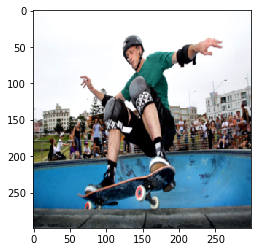

In [31]:
plt.imshow(img)

In [32]:
for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

a man is jumping in the air on a skateboard .
a man riding a skateboard on a ramp .
a man riding a skateboard on a ramp .
a man riding a skateboard on a ramp .
a man riding a skateboard on a ramp .
a man riding a skateboard on a skate board
a man riding a skateboard on a ramp .
a man riding a skateboard on a ramp .
a man riding a skateboard on a ramp .
a skateboarder is doing a trick on a skateboard .


--2018-11-13 23:07:38--  http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg
Resolving ccanimalclinic.com (ccanimalclinic.com)... 23.185.0.2, 2620:12a:8001::2, 2620:12a:8000::2
Connecting to ccanimalclinic.com (ccanimalclinic.com)|23.185.0.2|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106870 (104K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>] 104.37K  --.-KB/s    in 0.06s   

2018-11-13 23:07:38 (1.81 MB/s) - ‘data/img.jpg’ saved [106870/106870]



/home/nadya/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


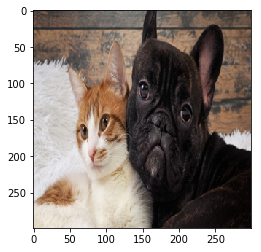

a black and white cat laying on a bed
a black and white cat laying on a bed
a black and white cat is laying on a bed .
a black and white cat is laying on a bed .
a black and white cat sitting on a bed .
a black and white dog laying on a bed
a black and white cat is laying down on a chair .
a black and white cat sitting on a chair .
a black and white cat is sleeping on a bed .
a black and white cat is laying on a bed .


In [33]:
!wget http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg -O data/img.jpg
img = plt.imread('data/img.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

# Demo
### Find at least 10 images to test it on.
* Seriously, that's part of an assignment. Go get at least 10 pictures to get captioned
* Make sure it works okay on __simple__ images before going to something more comples
* Photos, not animation/3d/drawings, unless you want to train CNN network on anime
* Mind the aspect ratio

/home/nadya/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  del sys.path[0]


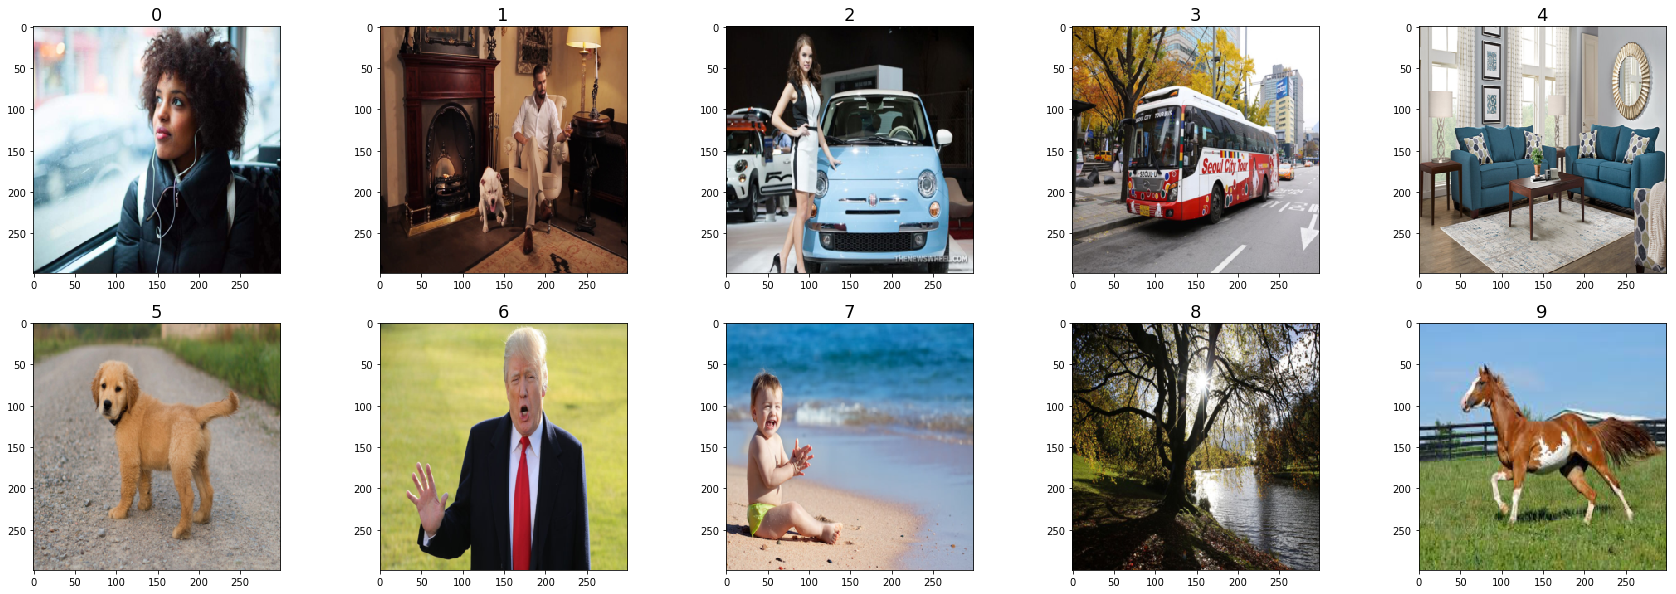

0 

a woman in a dress is holding a cell phone .
a woman in a dress is holding a cell phone .
a woman holding a cell phone in her hand .
a woman holding a cell phone in her hand .
a woman in a suit and tie is talking on a cell phone .


1 

a woman is sitting at a table with a cake .
a woman is holding a dog in a room .
a woman in a chair with a white dog and a dog .
a woman and a woman are playing a video game .
a man and a woman are sitting in a living room .


2 

a man in a suit and tie is walking down a street .
a man in a suit and tie is standing in the street .
a man is walking down the street with a dog .
a man in a car is riding a motorcycle .
a man in a suit and tie standing next to a bus .


3 

a bus is parked on the side of the street .
a red double decker bus driving down a street .
a red double decker bus is driving down a street .
a bus is parked on the side of the street .
a red double decker bus is parked on the street .


4 

a living room with a couch and a table .


In [50]:
#apply your network on image sample you found
#
#
from matplotlib import pyplot as plt
import os, os.path

path = "imgs/"
size = 299
imgs = []
for file in os.listdir(path):
    if file.endswith('.jpg') or file.endswith('.jpeg'):
        img = plt.imread(path + file)
        img = imresize(img, (size, size)).astype('float32') / 255.
        imgs.append(img)
fig = plt.figure(figsize=(30, 10))
for i, _ in enumerate(imgs):
    plt.subplot(2,5,i+1)
    plt.imshow(imgs[i])
    plt.title(i, fontdict = {'fontsize': 18})
plt.show()
for i, img in enumerate(imgs):
    print(i, '\n')
    for i in range(5):
        print(' '.join(generate_caption(img, t=5.)[1:-1]))
    print('\n')

### Now what?

Your model produces some captions but you still strive to improve it? You're damn right to do so. Here are some ideas that go beyond simply "stacking more layers". The options are listed easiest to hardest.

##### Attention
You can build better and more interpretable captioning model with attention.
* How it works: https://distill.pub/2016/augmented-rnns/
* One way of doing this in captioning: https://arxiv.org/abs/1502.03044
* You will have to create a dataset for attention with [this notebook](https://gist.github.com/justheuristic/11fd01f9c12c0bf960499580d104130b).

##### Subword level captioning
In the base version, we replace all rare words with UNKs which throws away a lot of information and reduces quality. A better way to deal with vocabulary size problem would be to use Byte-Pair Encoding

* BPE implementation you can use: [github_repo](https://github.com/rsennrich/subword-nmt). 
* Theory: https://arxiv.org/abs/1508.07909
* It was originally built for machine translation, but it should work with captioning just as well.

#### Reinforcement learning
* After your model has been pre-trained in a teacher forced way, you can tune for captioning-speific models like CIDEr.
* Tutorial on RL for sequence models: [practical_rl week8](https://github.com/yandexdataschool/Practical_RL/tree/master/week8_scst)
* Theory: https://arxiv.org/abs/1612.00563